In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.cross_validation import cross_val_score
from scipy import stats
#import xgboost as xgb
from sklearn.linear_model import Lasso, LassoCV, Ridge

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df = pd.read_csv('input/train_custom_2.csv', index_col=0)
test = pd.read_csv('input/test_custom_2.csv',index_col=0)

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

def rmse_cv(model, x, y):
    return np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))

rmse_scorer = metrics.make_scorer(rmse, greater_is_better=False)

In [6]:
y = df['SalePrice']
df.drop('SalePrice',1,inplace=True)

## Linear Regression (Ridge)

In [7]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), df, y).mean() for alpha in alphas]

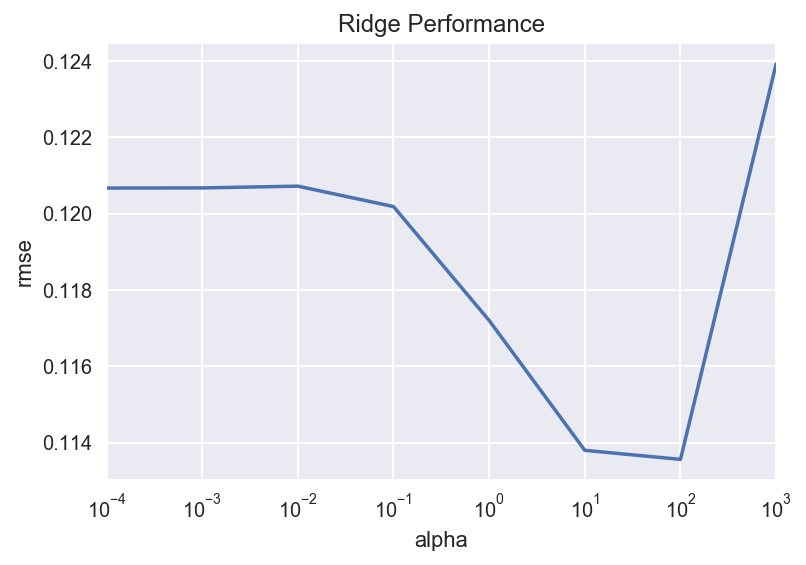

In [8]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Performance")
plt.xlabel("alpha")
plt.ylabel("rmse")
ax = plt.gca()
ax.set_xscale('log')

In [9]:
# Best Ridge RMSE
cv_ridge.min()

0.11356405187362451

In [10]:
model_ridge = Ridge(alpha=10, max_iter=50000)
model_ridge.fit(df, y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [11]:
# Run prediction on the Kaggle test set.
y_pred_ridge = model_ridge.predict(test)

## Linear Regression (LASSO)

In [15]:
# Finding alpha using SKLEARN CV
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,110,125,150,175,200]
model_lasso = LassoCV(alphas = alphas, cv=10).fit(df, y)

# Best Lasso RMSE
#print rmse_cv(model_lasso,df,y).mean()
# Best Lasso alpha
#print model_lasso.alpha_

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


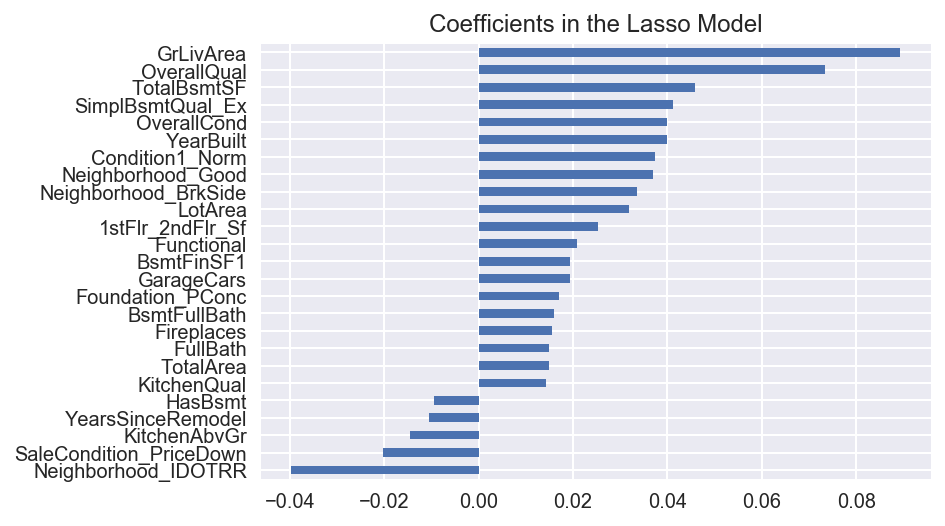

In [16]:
coef = pd.Series(model_lasso.coef_, index = test.columns)
imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(20)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [17]:
# Finding alpha using GRIDSEARCH
lasso = Lasso()
lasso_gs = model_selection.GridSearchCV(lasso, {'alpha': alphas}, cv=10,scoring=rmse_scorer)
lasso_gs.fit(df, y)

# Best Lasso RMSE
print(lasso_gs.best_score_)
# Best Lasso alpha
print(lasso_gs.best_params_)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

-0.111480550606
{'alpha': 0.001}


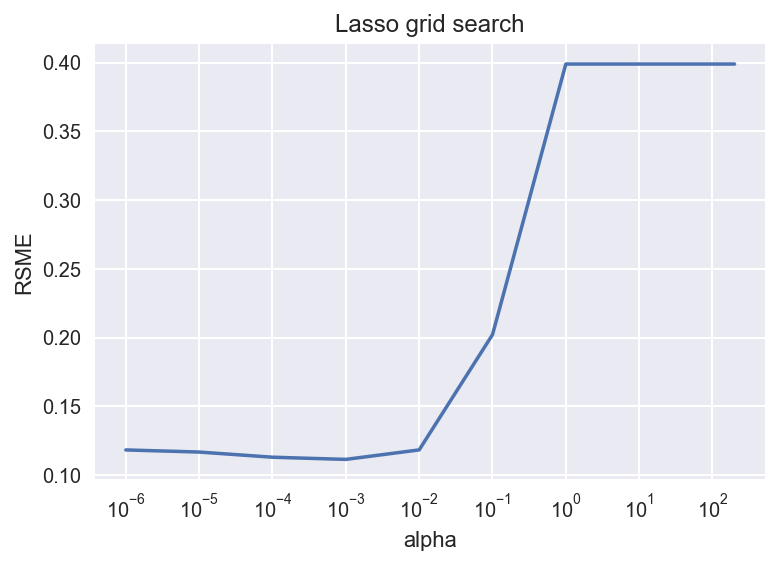

In [18]:
plt.plot([item['alpha'] for item in lasso_gs.cv_results_['params']], 
         [-item for item in lasso_gs.cv_results_['mean_test_score']])
plt.xlabel('alpha')
plt.ylabel('RSME')
plt.title('Lasso grid search')
ax = plt.gca()
ax.set_xscale('log')

In [19]:
#regr = Lasso(alpha=lasso_gs.best_params_['alpha'])
model_lasso.fit(df, y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 110, 125, 150, 175, 200],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [20]:
# Run prediction on the Kaggle test set.
y_pred_lasso = model_lasso.predict(test)

# Auto Sklean

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df, y, random_state=1)

In [ ]:
import autosklearn.regression
cls = autosklearn.regression.AutoSklearnRegressor()
cls.fit(X_train.values, y_train.values)
#predictions = cls.predict(X_test, y_test)

[WARNING] [2017-05-24 23:13:19,708:AutoMLSMBO(1)::73a1f83ff0877361916845d2b024d36e] Could not find meta-data directory /usr/local/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense


You are already timing task: index_run2
You are already timing task: index_run2
You are already timing task: index_run2
You are already timing task: index_run5


[WARNING] [2017-05-24 23:15:10,375:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:15:10,375:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run7


[WARNING] [2017-05-24 23:15:51,531:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:15:51,531:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run10
You are already timing task: index_run11
You are already timing task: index_run11


[WARNING] [2017-05-24 23:17:22,265:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:17:22,265:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:17:23,850:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:17:23,850:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run11


[WARNING] [2017-05-24 23:17:46,492:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:17:46,492:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run13
You are already timing task: index_run16
You are already timing task: index_run16
You are already timing task: index_run18
You are already timing task: index_run18
You are already timing task: index_run18


[WARNING] [2017-05-24 23:44:06,447:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:44:06,447:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run18
You are already timing task: index_run19


[WARNING] [2017-05-24 23:49:29,594:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:49:29,594:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:49:34,699:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-05-24 23:49:34,699:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run22
You are already timing task: index_run23
You are already timing task: index_run24
You are already timing task: index_run25
Process pynisher function call:
Process pynisher function call:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/usr/local/Cellar/python3

# XGBoost

In [84]:
model_xbg = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 learning_rate=0.01,
                 max_depth=6,
                 gamma=0.0,
                 min_child_weight=9,
                 n_estimators=7000,  
                 subsample=0.6,
                 seed=42)

In [85]:
rmse_cv(model_xbg, df, y).mean()

0.1166188873456903

In [86]:
model_xbg.fit(df, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=9, missing=None, n_estimators=7000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

In [87]:
# Run prediction on the Kaggle test set.
y_pred_xgb = model_xbg.predict(test)

In [88]:
y_pred = (y_pred_lasso + y_pred_xgb) / 2
y_pred = np.expm1(y_pred)

pred_df = pd.DataFrame(y_pred, index=test.index, columns=["SalePrice"])
pred_df.to_csv('output_ensemble_norm.csv', header=True, index_label='Id')